In [149]:
import time
tot_tic = time.time()
import matplotlib.pyplot as plt
from matplotlib import colormaps
import sys
import pandas as pd
import cantera as ct
import numpy as np
import tempfile
from scipy.interpolate import interp1d

In [109]:
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

In [110]:
injectants =        ['CCL4'] # list of injectants, must be in the mechanism file.
injectant_concs =   [100] # injected species concentrations in furnace @ injection point (ppm)
injectant_units =   ['wt%'] # units of injected species concentration in furnace @ injection point (ppm)
ER = 0.834 
injectant_tot_conc=20 # total injected species concentration in furnace @ injection point (ppm)
injectant_port = 4 # port number of injectant
firing_rate = 45 # firing rate in kW

post_injection_res_time_step = 1e-3 # residence time grid size (seconds)
elsewhere_res_time_step = 1e-2 # residence time grid size (seconds)

In [111]:
#converting concentration to mole fraction
mechanism = 'rei_chloro.yaml' # mechanism file
gas = ct.Solution(mechanism)
orig_concs = [i for i in injectant_concs]
#convert injectant_concs from specified unit to ppm
for i in range(len(injectant_concs)):
    if injectant_units[i] == 'ppb':
        injectant_concs[i] = injectant_concs[i] * 1e3
    elif injectant_units[i] == 'ppm':
        injectant_concs[i] = injectant_concs[i]
    elif injectant_units[i] == 'pph':
        injectant_concs[i] = injectant_concs[i] * 1e-3
    elif injectant_units[i] == 'ng/g':
        injectant_concs[i] = injectant_concs[i] * 1e-3
    elif injectant_units[i] == 'mg/kg':
        injectant_concs[i] = injectant_concs[i]
    elif injectant_units[i] == 'wt%':
        injectant_concs[i] = injectant_concs[i] * 1e4
    else:
        raise ValueError("Unknown unit of concentration.")

#use ratio of injectant_concs to make the sum of the injectant_concs equal to injectant_tot_conc
injectant_concs = [i * injectant_tot_conc / sum(injectant_concs) for i in injectant_concs]

#make dictionary of injectants, concentrations, and units
compounds_info = []
for i in range(len(injectants)):
    compounds_info.append({'name': injectants[i], 'concentration': injectant_concs[i], 'unit': injectant_units[i]})

# Fetch the molar masses from Cantera for the compounds
molar_masses = {species.name: species.molecular_weight for species in gas.species()}

# Calculate moles for each compound based on the unit of concentration
total_moles = 0
for compound in compounds_info:
    compound_name = compound['name']
    if compound_name in molar_masses:
        molar_mass = molar_masses[compound_name]
        if compound['unit'] == 'ppb' or 'ng/g':
            # Convert ppb to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 1e-9) / molar_mass
        elif compound['unit'] == 'ppm' or 'mg/kg':
            # Convert ppm to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 1e-6) / molar_mass
        elif compound['unit'] == 'pph' or 'wt%':
            # Convert weight percent to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 0.01) / molar_mass
        else:
            raise ValueError("Unknown unit of concentration.")
        total_moles += compound['moles']
    else:
        raise ValueError(f"Molar mass for {compound_name} not found in mechanism file.")

# Calculate mole fractions
for compound in compounds_info:
    compound['mole_fraction'] = compound['moles'] / total_moles

#set injection_concs to mole fractions
injectant_concs = []
for compound in compounds_info:
    injectant_concs.append(compound['mole_fraction'])

In [112]:

def strclean(s):
    return str(s).replace(' ', '').replace('[','').replace(']','').replace("'",'')

#script to generate folder name based off specified conditions, using the format specified above.
if len(injectants) > 1:
    pollutant_index = 0
    output_folder = 'Output/AFFF/'+str(pollutant_index)+str(injectant_port)+'.'+str(firing_rate).replace('.','')+'_'+str(firing_rate)+'kW_'+strclean(injectants[:3])+'_port'+str(injectant_port)
else:
    if injectants[0] == 'CF4':
        pollutant_index = 1
    elif injectants[0] == 'CHF3':
        pollutant_index = 2
    elif injectants[0] == 'CHF6':
        pollutant_index = 3
    else:
        pollutant_index = 0
        
    output_folder = 'Output/'+str(pollutant_index)+str(injectant_port)+'.'+str(firing_rate).replace('.','')+'_'+str(firing_rate)+'kW_'+strclean(injectants)+'_port'+str(injectant_port)

    
if os.path.exists(output_folder) == False: #check if output folder exists
    os.makedirs(output_folder) #create output folder if it doesn't exist
    print('Creating new folder: ' + output_folder)
else:
    #open the run_conditions.txt file and check if the same conditions are being used for this run, if so, then continue. If not, make a subfolder in the run folder with the new conditions.
    # Write the current conditions to a temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        f.write('Injectants: '+ ', '.join(injectants) + '\n')
        f.write('Injectant Concentration (converted to mole fraction): '+ str(injectant_concs) + '\n')
        f.write('Injectant Total Concentration: '+ str(injectant_tot_conc) + '\n')
        f.write('Injectant Port: '+ str(injectant_port) + '\n')
        f.write('firing rate: ' + str(firing_rate) + '\n')

    # Read the contents of the temporary file and run_conditions.txt
    with open(f.name, 'r') as file1, open(output_folder+'/run_conditions.txt', 'r') as file2:
        file1_contents = [next(file1) for x in range(5)]
        file2_contents = [next(file2) for x in range(5)]
    print(file1_contents)
    print(file2_contents)
    # Check if the contents are the same
    if file1_contents == file2_contents:
        # rest of your code
        print('Same conditions, continuing with run')
    else:
        print('Different conditions, creating subfolder')
        conditions = '_'.join([strclean(injectants[i])+'-'+str(injectant_concs[i])[:5] for i in range(len(injectants))[:5]])+'_'+str(injectant_tot_conc)+'_'+str(injectant_port)+'_'+str(firing_rate)
        print(conditions)
        output_folder = output_folder+'/'+conditions
        if os.path.exists(output_folder) == False:
            os.makedirs(output_folder) #create output folder if it doesn't exist

file = open(f'{output_folder}/log.txt', 'w') #create log file
file.close() #close log file



['Injectants: CCL4\n', 'Injectant Concentration (converted to mole fraction): [1.0]\n', 'Injectant Total Concentration: 20\n', 'Injectant Port: 4\n', 'firing rate: 45\n']
['Injectants: CCL4\n', 'Injectant Concentration (converted to mole fraction): [1.0]\n', 'Injectant Total Concentration: 20\n', 'Injectant Port: 4\n', 'firing rate: 45\n']
Same conditions, continuing with run


In [113]:
########## System conditions ##########
lengths = [36,13,133,97] # inches
diameters = [20.5,15.5,10.5,8] # inches

SR_275 = 2.161
SR_30 = 2.0
SR_32 = 1.842
SR_34 = 1.737
SR_35 = 1.67
SR_395 = 1.5
SR_41 = 1.42
SR_43 = 1.357
SR_45 = 1.295

exhaust_275 = 920 + 44.7
exhaust_30 = 920.3 + 48.7
exhaust_32 = 912 + 52
exhaust_34 = 910 + 55
exhaust_395 = 906 + 64.0
exhaust_41 = 898 + 66.6
exhaust_43 = 902 + 69.8
exhaust_45 = 900 + 73

measured_temps_275 = [927,864,819,753,711,655,501,449,399,364] # °C
measured_temps_30 = [931, 906, 850, 803, 763, 712, 526, 477, 430, 391]
#measured_temps_32 = 
#measured_temps_34 =
#measured_temps_35 = 
measured_temps_395 = [1074, 1065, 996, 948, 889, 826, 598, 549, 497, 441]
#measured_temps_41 = 
#measured_temps_43 = 
measured_temps_45 = [1198, 1177, 1116, 1055, 997, 916, 649, 602, 553, 491]

inject_dist_port1 = 6 # inches
inject_dist_port4 = 55 # inches
inject_dist_port6 = 79  # inches
inject_dist_port8 = 103 # inches


firing_rate = output_folder.split('_')[0]
firing_rate = firing_rate.split('.')[1]
if firing_rate == '275':
    SR = SR_275 # stoichiometric ratio
    exhaust_gas_q = exhaust_275 # total volumetric flow rate (L/min)
    measured_temps = measured_temps_275 # °C
    firing_rate = '27.5'
elif firing_rate == '45':
    SR = SR_45
    exhaust_gas_q = exhaust_45
    measured_temps = measured_temps_45
elif firing_rate == '395':
    SR = SR_395
    exhaust_gas_q = exhaust_395
    measured_temps = measured_temps_395
elif firing_rate == '30':
    SR = SR_30
    exhaust_gas_q = exhaust_30
    measured_temps = measured_temps_30

if output_folder.split('_')[3] == 'port1':
    injection_loc = inject_dist_port1 # inches, see files\rainbow_ports.txt for list of port locations
elif output_folder.split('_')[3] == 'port4':
    injection_loc = inject_dist_port4 # inches, see files\rainbow_ports.txt for list of port locations
elif output_folder.split('_')[3] == 'port6':
    injection_loc = inject_dist_port6 # inches, see files\rainbow_ports.txt for list of port locations
elif output_folder.split('_')[3] == 'port8':
    injection_loc = inject_dist_port8


########## Mechanism ##########
#mechanism = 'NCSU_PFASmech1.0.yaml' # mechanism file, irrelevant if 'yaml' = False

yaml = True # if False, below chemkin format files will be converted to a Cantera friendly yaml file
kinetics = 'NCSU_PFASmech1.91_Kinetics.inp'
thermo = 'NCSU_PFASmech1.9_Thermo.dat'
output = 'new_mech_file.yaml' # must have .yaml extension

########## Temperature fitting ##########
measured_temps_locs = [18,55,79,103,127,151,201,225,249,273] # inches
ff = 0.9 # "fudge factor" for flame temp because Cantera's solution is adiabatic
spline = True # fit using scipy.interpolate.UnivariateSpline (True) or numpy.polyfit (False)
k = 3 # spline degree
s = None # spline smoothing factor, see scipy documentation for guidance
pdeg = 4 # polynomial degree, only appliciable if 'spline' is set to False

########## Path diagram ##########
path_res_time = 0.001 # seconds, precision will be limited by grid resolution settings
path_element = 'F' # case sensitive
path_species = 'all' # 'all' or individual species name to only display fluxes connected to that species
path_threshold = 0.0001 # kmol/m3/sec
path_details = False # or True

########## Grid resolution ##########

post_injection_duration = 1e-1 # seconds
########## Additional settings ##########
run_with_dialog = False # Running with dialog may be best for public distributions
print_info_every = 100 # print simulation info every n time steps
atol = 1e-15 # absolute error tolerance for reactor equations solver
rtol = 1e-9 # relative error tolerance for reactor equations solver
it0 = True # generate output with pre-injection data trimmed off (True) or not trimmed (False)
concentrations_interactive_plot_cutoff = 1e-9 # mol fraction
rates_interactive_plot_cutoff = 1e-9 # mol/m3/s
save_rates_solution = False # Generating the net rates excel spreadsheet adds a lot of wall time
individual_plots = False # Generating individual species concentration plots adds a lot of wall time
major_species_cutoff = 1e-6 # mol fraction
minor_species_cutoff = 1e-15 # mol fraction

#write output folder, firing rate, injection loc, injectant, injection concentration, and mechanism to a single file for reference
with open(output_folder+'/run_conditions.txt', 'w') as f: 
    f.write('Injectants: '+ ', '.join(injectants) + '\n')
    f.write('Injectant Concentration (converted to mole fraction): '+ str(injectant_concs) + '\n')
    f.write('Injectant Total Concentration: '+ str(injectant_tot_conc) + '\n')
    f.write('Injectant Port: '+ str(injectant_port) + '\n')
    f.write('firing rate: ' + firing_rate + '\n')



    f.write('output folder: ' + output_folder + '\n')
    
    f.write('injection location: ' + str(injection_loc) + '\n')
    
    f.write('Injectant Concentrations Input: '+ str(orig_concs) + '\n')
    
    f.write('Mechanism: ' + mechanism + '\n')
    f.write('SR: ' + str(SR) + '\n')
    f.write('ER: ' + str(ER) + '\n')
    f.write('Exhaust Gas Flow Rate: ' + str(exhaust_gas_q) + '\n')
    f.write('Measured Temperatures: ' + str(measured_temps) + '\n')
    f.write('Measured Temperatures Locations: ' + str(measured_temps_locs) + '\n')
    

In [114]:
def myprint(txt): #print to console and log file
    print(txt, file=open(f'{output_folder}/log.txt', 'a'))
    print(txt)
    file.close()
    
def myinput(txt): #input to console and log file
    inp = input(txt)
    print(txt+inp, file=open(f'{output_folder}/log.txt', 'a'))
    file.close()
    return inp

In [115]:
import os
# restart function only works for executable, not in python interpreter
def restart_main():
    executable = sys.executable
    executable_filename = os.path.split(executable)[1]
    os.execv(executable, sys.argv)

while os.system('dot -V') == 1:
    myprint('graphviz must be installed on your PATH to generate reaction pathway diagrams')
    time.sleep(1)
    myinput('press enter to launch graphviz installer')
    
    path_to_file = 'files/'
    exe = 'graphviz-install.exe'
    cur_dir = os.getcwd()
    os.chdir(path_to_file) # change folder
    os.system(f'{exe}')
    os.chdir(cur_dir) # go back
    
    myprint('graphviz installed -> restarting PFRTP run...')
    
    restart_main()

In [116]:
if yaml == False and os.path.exists(output) == True:
    myprint('output mechanism yaml file already exists -> no mechanism file format conversion necessary...')
    mechanism = output
elif yaml == False:
    myprint('converting chemkin mechanism files to yaml file...')
    args = f' python -m cantera.ck2yaml --input={kinetics} --thermo={thermo} --output={output} --permissive'
    os.system(args)
    mechanism = output
else:
    ...

In [117]:
myprint(' ')
gri_names = list(ct.Solution('files/gri3.0.yaml').species_names)
mech_names = list(ct.Solution(mechanism).species_names)
notin = []
for species in gri_names:
    if species in mech_names:
        ...
    else:
        notin.append(species)

if notin:
    myprint('WARNING! PFRTP uses the GRI-Mech 3.0 kinetic mechanism to estimate the composition of flame off-gas given the input stoichiometric ratio. '+
            'The subsequent evolution of that gas in the PFR system is based on the input kinetic mechanism.'+
            ' GRI-Mech 3.0 contains '+str(len(notin))+' species that were not identified in the input mechanism: '+" ".join(notin))
    myprint('You may wish to (a) check if any of the listed species are included in the input mechanism using a different name and rename them accordingly and/or (b) confirm that the listed species are not relevant in this case.')
    myprint('The GRI-Mech 3.0 file used by PFRTP can be found at files')
    myprint(' ')
    myprint(' ')
else:
    ...

In [118]:
# Burn a flame and save the off-gas state as a yaml file.

fname = 'files/flames/'+'flame_'+str(SR)+'.yaml'
if os.path.exists(fname) == False:
    myprint('flame solution does not exist for input SR -> solving flame...')
    To = 300
    Po = 101325
    gas = ct.Solution('files/gri3.0.yaml')
    gas.set_equivalence_ratio(ER, "CH4", {"O2": 1.0, "N2": 3.76})
    gas.TP = To, Po
    flame = ct.FreeFlame(gas)
    flame.solve(auto=True, loglevel=1)
    flame.gas.write_yaml(fname)
    myprint('flame solved -> creating polynomial fit for temperature profile...')
else:
    myprint('flame solution exists for input SR -> fitting temperature profile...')

flame solution exists for input SR -> fitting temperature profile...


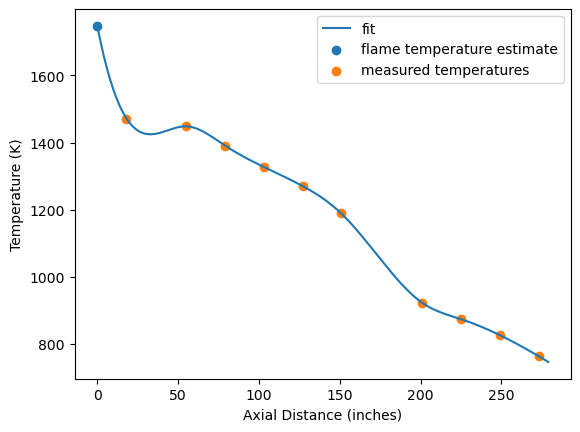

In [119]:
# Convert user input to model-friendly input

flame_temp_estimate = ct.Solution(fname).T*ff

if 0 in measured_temps_locs:
    measured_temps_new = [x+273.15 for x in measured_temps]
    measured_temps_locs_new = measured_temps_locs
else:
    measured_temps_new = [flame_temp_estimate]+[x+273.15 for x in measured_temps]
    measured_temps_locs_new = [0] + measured_temps_locs

# fit temps to axial length (a reasonable simplification)
xf = range(sum(lengths)+1)
if spline == True:
    spl = interpolate.UnivariateSpline(measured_temps_locs_new, measured_temps_new, k=k, s=s)
    T_fit = spl(xf)
else:
    z = np.polyfit(measured_temps_locs_new, measured_temps_new, pdeg)
    f = np.poly1d(z)
    T_fit = np.round(f(xf), 0) #### don't need round anymore?

# Plot fit
plt.plot(xf,T_fit,label='fit')
if 0 in measured_temps_locs:
    plt.scatter(measured_temps_locs,measured_temps_new,label='measured')
else:
    plt.scatter(0,flame_temp_estimate,label='flame temperature estimate')
    plt.scatter(measured_temps_locs,measured_temps_new[1:],label='measured temperatures')
plt.ylabel('Temperature (K)')
plt.xlabel('Axial Distance (inches)')
plt.legend()
plt.savefig(output_folder+'\\temperature_fit_axial_distance.png',dpi=300,
                    bbox_inches='tight',facecolor='white')
plt.show()

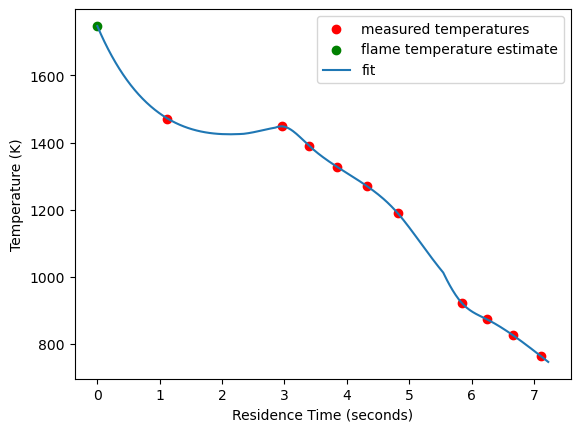

In [120]:
# Convert axial length fit to residence time fit based on slice volumes, temperatures, and flow rates

# start by making list of slice volumes, slices have 1-inch lengths
v = [0]
for l,d in zip(lengths,diameters):
    slice_lengths = np.zeros(l) + 1 # a list of "1"s the length of the nth section
    slice_vols = slice_lengths * np.pi * d**2 / 4 # a list of the corresponding volumes
    v.extend(list(slice_vols)) # extend the total list of volumes
    
Q = exhaust_gas_q * T_fit / 293.15 # list of T-corrected flows through each volume (L/min) based on ideal gas law
res_t = 60*np.array(v)/(61*Q) # list of slice res times (seconds), divided by 61 to convert L/min to in^3/min
t_cum = np.cumsum(res_t) # a list of slice cumulative res times (seconds)

# Plot fit
if 0 in measured_temps_locs:
    plt.scatter(t_cum[np.round(measured_temps_locs,0)],measured_temps_new,c='red',label='measured')
else:
    plt.scatter(t_cum[np.round(measured_temps_locs,0)],measured_temps_new[1:],c='red',label='measured temperatures')
    plt.scatter(t_cum[0],measured_temps_new[0],c="green",label='flame temperature estimate')
plt.plot(t_cum,T_fit,label='fit')
plt.ylabel('Temperature (K)')
plt.xlabel('Residence Time (seconds)')
plt.legend()
plt.savefig(output_folder+'\\temperature_fit_res_time.png',dpi=300,
                    bbox_inches='tight',facecolor='white')
plt.show();

In [121]:
myprint('plots of temperature profile fit saved to output folder')
if run_with_dialog == True:
    time.sleep(2)
    myinput('if satisfied with fit, press enter to run PFR simulation')
else:
    ...
myprint('PFR simulation running...')

plots of temperature profile fit saved to output folder
PFR simulation running...


In [122]:
# Interpolate res time fit to user-defined resolution
i_t = t_cum[np.round(injection_loc,0)] #res time at injection location

tgap1 = np.zeros(int(i_t/elsewhere_res_time_step)) + elsewhere_res_time_step # time steps before injection

tinj = np.zeros(int(post_injection_duration/post_injection_res_time_step)) + post_injection_res_time_step # time steps during injection

tgap2 = np.zeros(int((t_cum[-1]-i_t-post_injection_duration)/elsewhere_res_time_step)) + elsewhere_res_time_step # time steps after injection
 
tnew = np.concatenate(([0],tgap1,[i_t-sum(tgap1)],tinj,tgap2)) # list of res times (seconds) at user-defined resolution
f = interpolate.interp1d(t_cum, T_fit)  # interpolate temperature fit to res time fit, using t_cum as x and T_fit as y
Tnew = f(np.cumsum(tnew))

In [123]:
# define a function to map gri flame-gas species concentrations to mechanism species concentrations

def gri_to_mech(mech):
    gri_species = list(ct.Solution('files/gri3.0.yaml').species_names)
    mech_species = list(ct.Solution(mechanism).species_names)
    gri_c = list(ct.Solution(fname).X)
    mech_c = list(ct.Solution(mechanism).X)
    for species in gri_species:
        if species in mech_species:
            mech_c[mech_species.index(species)] = gri_c[gri_species.index(species)]
        else:
            ...
    return mech_c

In [124]:
# define the simulation loop for the res time vs. temp profile

def sim(T,t):
    intic = time.time()
    gas1,r1,sim1 = None,None,None
    pressure = ct.one_atm  # constant pressure [Pa]
    gas1 = ct.Solution(mechanism)
    concentrations = gri_to_mech(mechanism)
    rates = list(gas1.net_rates_of_progress)

    # determine index of injectant
    injectant_indices = [ct.Solution(mechanism).species_index(injectant) for injectant in injectants]

    c=[]
    nrp=[]
    flag = False
    timestep = 0
    loop_t_cum = 0
    inj_i = len(tgap1)+2

    for T_i, t_i in zip(T,t):
        
        if timestep >= inj_i and flag == False:
            for i, conc in enumerate(injectant_concs):
                concentrations[injectant_indices[i]] = conc
            flag = True
        else:
            ...

        # wait to append concentrations until time of injection if it0 == True
        if it0 == False or flag == True:
            c.append(concentrations)
            nrp.append(rates)
        else:
            ...

        gas1.TPX = T_i, pressure, concentrations
        r1 = ct.IdealGasConstPressureReactor(gas1,energy="off")
        sim1 = ct.ReactorNet([r1])
        sim1.atol = atol
        sim1.rtol = rtol
        sim1.advance(t_i)
        concentrations = list(r1.thermo.X)
        rates = list(r1.thermo.net_rates_of_progress)

        timestep+=1
        loop_t_cum += t_i
        if (timestep % print_info_every == 0):
            intoc = time.time()
            myprint(
                f'timestep: {timestep}   total residence time (s): {str(round(loop_t_cum, 4))}   temperature (K): {str(round(T_i, 2))}   elapsed wall time(s): {str(round(intoc - intic, 2))}'
            )

    return c, nrp

In [125]:
# run the simulation
tic = time.time()
sim_data, nrp = sim(Tnew,tnew)
toc = time.time()
myprint(
    f'PFR simulation completed with wall time of: {str(round(toc - tic, 2))} seconds'
)
import winsound
winsound.Beep(440, 1000)

timestep: 100   total residence time (s): 0.99   temperature (K): 1488.1   elapsed wall time(s): 3.85
timestep: 200   total residence time (s): 1.99   temperature (K): 1425.3   elapsed wall time(s): 6.59
timestep: 300   total residence time (s): 2.9619   temperature (K): 1448.26   elapsed wall time(s): 8.88
timestep: 400   total residence time (s): 3.0889   temperature (K): 1440.0   elapsed wall time(s): 13.62
timestep: 500   total residence time (s): 4.0889   temperature (K): 1298.75   elapsed wall time(s): 20.49
timestep: 600   total residence time (s): 5.0889   temperature (K): 1124.82   elapsed wall time(s): 26.97
timestep: 700   total residence time (s): 6.0889   temperature (K): 887.87   elapsed wall time(s): 32.68
timestep: 800   total residence time (s): 7.0889   temperature (K): 766.97   elapsed wall time(s): 37.65
PFR simulation completed with wall time of: 38.28 seconds


In [126]:
# generate excel files
myprint(' ')
if run_with_dialog == True:
    time.sleep(2)
    myinput('press enter to generate output')
else:
    ...
myprint('generating and saving output to output folder...')

 
generating and saving output to output folder...


In [127]:
cantera_species = ct.Solution(mechanism).species_names
tplot = np.concatenate(([0],np.cumsum(tinj),np.cumsum(tgap2)+sum(tinj)))[:-1]
Tplot = Tnew[len(tnew)-len(sim_data):]

sim_data_new = list(np.array(sim_data).T)
sim_data_new.insert(0,Tplot)
sim_data_new.insert(0,tplot)
sol = np.array(sim_data_new).T
columns = ['Residence Time (seconds)','Temperature (K)'] + cantera_species
pd.DataFrame(sol,columns=columns).to_excel(output_folder+"\\solution_concentrations.xlsx")

In [128]:
#spent way too much time making an interactive plot, but it's pretty cool
import ipywidgets as widgets
from ipywidgets import HTML
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# List to store the species to plot
species_to_plot = ['CO','H', 'CL', 'CCL4','HCL','CLO','CCLO','CL2']
# Calculate the minimum and maximum concentrations for each species
concentrations_glob = {species: sol[:, columns.index(species)] for species in species_to_plot}

from ipywidgets import Label, GridBox, Layout

# Create a list of HTML widgets with the titles as their values
titles = [HTML('<p style="font-size:10px; text-align:center; margin:0; line-height:1;">Species</p>'), 
          HTML('<p style="font-size:10px; text-align:center; margin:0; line-height:1;">Color</p>'), 
          HTML('<p style="font-size:10px; text-align:center; margin:0; line-height:1;">Max Concentration</p>'), 
          HTML('<p style="font-size:10px; text-align:center; margin:0; line-height:1;">Min Concentration</p>'), 
          HTML('<p style="font-size:10px; text-align:center; margin:0; line-height:1;">Avg Concentration</p>'), 
          HTML('<p style="font-size:10px; text-align:center; margin:0; line-height:1;">Residence Time</p>')]


# Initialize table_data with the titles


In [158]:

def table_maker(species_to_plot, concentrations_glob, colors=None):
    global table_data
    table_data=[]
    table_data.clear()
    table_data.extend(titles)
    for species in species_to_plot:
        min_concentration = np.min(concentrations_glob[species])
        max_concentration = np.max(concentrations_glob[species])
        avg_concentration = np.mean(concentrations_glob[species])
        if colors and species in colors:
            # Convert color from (r, g, b) to "rgb(r, g, b)"
            color = colors[species]
            color = tuple(int(c * 255) for c in color)  # Convert from 0-1 to 0-255
            color = f"rgba{color}"  # Convert to string in the format "rgb(r, g, b)"
        else:
            color = plt.get_cmap('viridis')(species_to_plot.index(species) / len(species_to_plot))  # Get a color from the viridis colormap
            color = tuple(int(c * 255) for c in color[:3])  # Convert from 0-1 to 0-255
            color = f"rgb{color}"  # Convert to string in the format "rgb(r, g, b)"
        color_html = f'<hr style="border-top: 3px solid {color};width: 15px; margin: 15px auto 0 auto; vertical-align: middle;">'  # Add more top margin
        residence_time = tplot[np.where(concentrations_glob[species] <= max_concentration * 0.01)[0][0]] if any(concentrations_glob[species] <= max_concentration * 0.01) else 'N/A'  # Calculate the residence time when the concentration has declined to 1% of its maximum concentration
        table_data.extend([Label(species), HTML(color_html), Label(f'{max_concentration:.3f}'), Label(f'{min_concentration:.3f}'), Label(f'{avg_concentration:.3f}'), Label(f'{residence_time}')])
    #make a detailed print statement for debugging to see the colors of each species

table_maker(species_to_plot, concentrations_glob)

def filter_species(change):
    search_input = change['new']
    if search_input == '':
        # If the search box is empty, display all species
        species_select.options = cantera_species
    else:
        # If the search box is not empty, display only the species that contain the search input
        species_select.options = [spec for spec in cantera_species if search_input.lower() in spec.lower()]

def add_species(b):
    global species_to_plot
    print(f'adding species {species_select.value} to plot')
    for species in species_select.value:
        if species not in species_to_plot_widget.options:
            species_to_plot.append(species)  # Update the species_to_plot list
        if isinstance(species_select.value, tuple):
            species_to_add = species_to_plot_widget.value
        elif isinstance(species_to_plot_widget.value, str):
            species_to_add = (species_to_plot_widget.value,)
        else:
            species_to_add = ()
    #append species_to_add to species_to_plot
    species_to_plot = species_to_plot + list(species_to_add)
    species_to_plot_widget.options = species_to_plot
    update_plot()

def remove_species(b):
    species_to_remove = species_to_plot_widget.value
    print(f'removing species {species_to_remove} from plot')
    global species_to_plot
    species_to_plot = [species for species in species_to_plot if species not in species_to_remove]
    species_to_plot_widget.options = species_to_plot
    species_to_plot_widget.value=()
    species_select.value = ()
    update_plot()

def clear_species(b):
    print('clearing all species from plot')
    global species_to_plot
    species_to_plot = ['H']
    species_to_plot_widget.options = species_to_plot
    update_plot()

def update_ylim_slider_max():
    max_concentration = 0
    for spec in species_to_plot:
        concentrations = sol[:, columns.index(spec)]
        max_concentration = max(max_concentration, np.max(concentrations))
    ylim_slider.max = max_concentration if float(max_concentration) > 0 else 0

def update_plot(change=None):
    plt.close('all')
    global species_to_plot
    global concentrations_glob

    plot_output.clear_output(wait=True)  # Clear the current output
    # Assume these are the width and height of the widget in pixels

    
    concentrations_glob = {species: sol[:, columns.index(species)] for species in species_to_plot}
    if not isinstance(species_to_plot, (list, tuple)):
        species_to_plot = [species_to_plot]
    

    pixel_x = 800
    pixel_y = 800
    inch_x = pixel_x / plt.rcParams["figure.dpi"]
    inch_y = pixel_y / plt.rcParams["figure.dpi"]

    _, ax = plt.subplots(figsize=(inch_x, inch_y))
    xlim_slider.value=(xlim_text_min.value,xlim_text_max.value)
    cmap = colormaps['nipy_spectral'] # Replace 'viridis' with the name of the color map you want to use
    colors = [cmap(i) for i in np.linspace(0, 1, len(species_to_plot))]
    global color_dict
    color_dict = {}
    for i, spec in enumerate(species_to_plot):
        mask = (tplot >= xlim_slider.value[0]) & (tplot <= xlim_slider.value[1])
        concentrations = sol[mask, columns.index(spec)]
        color_dict[spec] = colors[i]
        ax.plot(tplot[mask], concentrations, label=spec, color=colors[i])
    #make dictionary of colors for each species
    table_maker(species_to_plot, concentrations_glob, color_dict)
    table_data_grid.children = tuple(table_data)
    label_visible_lines(ax, ax.get_lines())
    ax.set_xlabel('Residence Time (seconds)')
    ax.set_ylabel('Concentration (mol/m^3)')
    ax.set_xlim(xlim_slider.value)
    ax.set_ylim([-0.05*ylim_slider.value, ylim_slider.value])  # Set the lower limit of the y-axis to 0
    ax.set_title('Concentration (<{:.3e}) vs. Residence Time ({} s)'.format(ylim_slider.value, xlim_slider.value[1]))
    update_ylim_slider_max()
    with plot_output:
        plt.show()
    # Update the maximum of the ylim slider
    
def update_text_min(*args):
    xlim_text_min.value = xlim_slider.value[0]

def update_text_max(*args):
    xlim_text_max.value = xlim_slider.value[1]

def find_visible_segment(line, xlim):
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    mask = (xdata >= xlim[0]) & (xdata <= xlim[1])
    return xdata[mask], ydata[mask]

def calculate_midpoints(lines, xlim):
    midpoints = []
    for line in lines:
        visible_x, _ = find_visible_segment(line, xlim)
        if len(visible_x) > 0:
            mid = (visible_x.min() + visible_x.max()) / 2
            midpoints.append(mid)
        else:
            midpoints.append(None)
    return midpoints

def distribute_midpoints(midpoints, xlim):
    # Identify unique midpoints and sort them
    unique_midpoints = sorted(set(midpoints))

    # Create a dictionary to map each unique midpoint to its duplicates
    midpoint_groups = {m: [] for m in unique_midpoints}
    for i, m in enumerate(midpoints):
        midpoint_groups[m].append(i)

    # Prepare a list to hold the new distributed x-values
    distributed_xvals = [None] * len(midpoints)

    for m in unique_midpoints:
        indices = midpoint_groups[m]
        if len(indices) > 1: # If there are duplicates
            # Find neighboring unique midpoints or use plot boundaries
            left_bound = unique_midpoints[unique_midpoints.index(m) - 1] if unique_midpoints.index(m) > 0 else xlim[0]
            right_bound = unique_midpoints[unique_midpoints.index(m) + 1] if unique_midpoints.index(m) < len(unique_midpoints) - 1 else xlim[1]

            # Distribute x-values evenly between the bounds
            new_xvals = np.linspace(left_bound, right_bound, len(indices) + 2)[1:-1]

            # Assign new x-values to the original indices
            for orig_idx, new_x in zip(indices, new_xvals):
                distributed_xvals[orig_idx] = new_x
        else:
            # If no duplicates, keep the original midpoint
            distributed_xvals[indices[0]] = m

    return distributed_xvals

def find_valid_x_for_label(line, proposed_x, xlim, ylim):
    """Find a valid x within the plot limits where the label can be placed, avoiding the outer 5%."""
    xdata, ydata = line.get_xdata(), line.get_ydata()
    if len(xdata) == 1: # Line has only one point
        return xdata[0]

    # Calculate the 5% margin for x and y limits
    x_margin = 0.08 * (xlim[1] - xlim[0])
    y_margin = 0.08 * (ylim[1] - ylim[0])
    x_min_limit = xlim[0] + x_margin
    x_max_limit = xlim[1] - x_margin
    y_min_limit = ylim[0] + y_margin
    y_max_limit = ylim[1] - y_margin

    # Create interpolation function
    f = interp1d(xdata, ydata, kind='linear', bounds_error=False, fill_value='extrapolate')

    # Check if the proposed x is valid within the reduced limits
    if x_min_limit <= proposed_x <= x_max_limit and y_min_limit <= f(proposed_x) <= y_max_limit:
        return proposed_x

    # Search for a valid x within the reduced limits
    search_points = np.linspace(x_min_limit, x_max_limit, 500) # Search within reduced limits
    for new_x in search_points:
        y = f(new_x)
        if y_min_limit <= y <= y_max_limit:
            return new_x

def label_plot_lines(ax):
    '''Labels the lines in the provided Axes object, avoiding edges and overlaps'''
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    lines = ax.get_lines()
    midpoints = calculate_midpoints(lines, xlim)
    xvals = distribute_midpoints(midpoints, xlim)
    adjusted_xvals = [find_valid_x_for_label(line, x, xlim, ylim) for line, x in zip(lines, xvals)]

    labelLines(lines, xvals=adjusted_xvals, align=True)


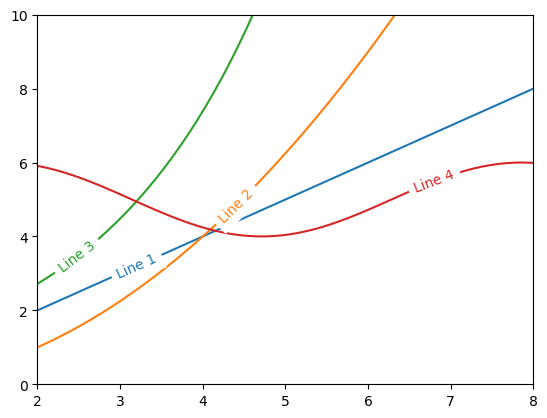

In [159]:
plt.figure()
#make a bunch of lines, using linear, polynomial, exponential, and trigonometric functions
x = np.linspace(0, 10, 100)
y1 = x
y2 = (x/2)**2
y3 = np.exp(x/2)
y4 = np.sin(x) +5


plt.plot(x ,y1, label='Line 1')
plt.plot(x, y2, label='Line 2')
plt.plot(x, y3, label='Line 3')
plt.plot(x, y4, label='Line 4')
plt.xlim(2, 8)
plt.ylim(0, 10)

ax = plt.gca()
label_plot_lines(ax)
